# Actor determination method 2: Based on threat reports
This notebook depicts the second methodology for actor determination as described in the corresponding master thesis. Threat reports are used as a basis for determining active threats and actors over a period in time.
Using public sources a base of threat actor names is created, which is used to scan the threat reports. The number of hits per reports is noted and used to determine the importance of a threat actor within a report. This data is then further enriched using public data sources. A graphical representation is depicted in the image below.

The enriched data can then be filtered on the sector and the actors and TTPs will be ranked using the ranking functions. These ranked TTPs are then mapped to controls in order to obtain a prioritization of security controls.

![Diagram representation of method 1](./docs/images/Method2.png)

## 1. Determine relevant threats  and actors
### 1.1. Get actor data and TTPs used

In [157]:
import pandas as pd

SECTOR = 'Government'

YEAR = 2021

TTP_THRESHOLD = 0

import pandas as pd

merge_df = pd.read_json('ETDA_ATTCK_merge.json',encoding='utf-8')
# df = pd.DataFrame(merge_list)
# merge_df['etda_operation_year'].explode().value_counts().sort_index().plot(kind='bar',title="Operations over the years")


#### 1.2. Preprocessing

In [158]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list if len(x) > 1]) # Convert column of lists to one list and remove single character values

agg_dict = {}
for column in merge_df.columns:
    if column == 'mitre_attack_ttps':
        agg_dict[column] = 'sum'
    else:
        agg_dict[column] = 'first'

merge_df = merge_df.groupby(['etda_name']).agg(agg_dict)
merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())

C:\Users\a.winters\AppData\Local\Temp\ipykernel_9584\773326629.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())


In [159]:
merge_df

,mitre_attack_id,mitre_attack_name,mitre_attack_aliases,mitre_attack_created,mitre_attack_last_modified,mitre_url,etda_id,etda_name,etda_aliases,etda_first_seen,etda_url,etda_operation_dates,etda_operation_year,country,motivation,victim_industries,victim_countries,mitre_attack_ttps
etda_name,,,,,,,,,,,,,,,,,,
"ALPHV, BlackCat Gang",Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2670c199-9e61-49ea-b587-467cff960c5c,"ALPHV, BlackCat Gang","[ALPHV, ALPHVM, BlackCat Gang]",2021,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,"[2021-12, 2021-12, 2022-01, 2022-01, 2022-02, ...","[2021, 2021, 2022, 2022, 2022, 2022, 2022, 202...",None Provided,[Financial gain],None Provided,None Provided,[Not Available]
ALTDOS,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0d49b800-c289-48a6-a2f9-c9cfba116e21,ALTDOS,[ALTDOS],2020,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,"[2020-12, 2021-01, 2021-01, 2021-03, 2021-05, ...","[2020, 2021, 2021, 2021, 2021, 2021, 2021, 2021]",None Provided,[Financial gain],None Provided,"[Bangladesh, Malaysia, Singapore, Thailand]",[Not Available]
"APT 12, Numbered Panda",intrusion-set--c47f937f-1022-4f42-8525-e7a4779...,APT12,"[APT12, IXESHE, DynCalc, Numbered Panda, DNSCALC]",2017-05-31,2020-03-30,https://attack.mitre.org/groups/G0005,a85ba864-0a13-4337-bd57-8df380b7b4fa,"APT 12, Numbered Panda","[APT 12, Numbered Panda, CTG-8223, Bronze Glob...",2009,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,"[2009-07, 2011-05, 2011, 2012-10, 2012-10, 201...","[2009, 2011, 2011, 2012, 2012, 2014, 2014, 201...",CN,[Information theft and espionage],"[Defense, Government, High-Tech, Media, Teleco...","[Germany, Japan, Taiwan, USA]","[T1568.003, T1566.001, T1204.002, T1102.002, T..."
"APT 16, SVCMONDR",intrusion-set--d6e88e18-81e8-4709-82d8-973095d...,APT16,[APT16],2017-05-31,2022-07-26,https://attack.mitre.org/groups/G0023,96d67d0e-dff0-4bbd-99fa-6dbdb433474f,"APT 16, SVCMONDR","[APT 16, SVCMONDR]",2015,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,[],[],CN,[Information theft and espionage],"[Financial, Government, High-Tech, Media]","[Japan, Taiwan, Thailand]",[T1584.004]
"APT 17, Deputy Dog, Elderwood, Sneaky Panda",intrusion-set--03506554-5f37-4f8f-9ce4-0e9f01a...,Elderwood,"[Elderwood, Elderwood Gang, Beijing Group, Sne...",2018-04-18,2021-03-02,https://attack.mitre.org/groups/G0066,58f101e3-5fe8-43d4-8d92-f09987604385,"APT 17, Deputy Dog, Elderwood, Sneaky Panda","[APT 17, Tailgater Team, Elderwood, Elderwood ...",2009,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,"[2009, 2010-11, 2012-05, 2012-07, 2013-08, 201...","[2009, 2010, 2012, 2012, 2013, 2013, 2014, 201...",CN,[Information theft and espionage],"[Defense, Education, Energy, Financial, Govern...","[Belgium, China, Germany, Indonesia, Italy, Ja...","[T1189, T1203, T1204.002, T1566.002, T1204.001..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[Unnamed group Iran],Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,01106777-4eb0-4a37-b7d3-c8ca539e2403,[Unnamed group Iran],[Unnamed group Iran],2019,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,[],[],IR,[Information theft and espionage],"[Aviation, Government, IT, Telecommunications]","[Afghanistan, Australia, Azerbaijan, Bahrain, ...",[Not Available]
[Unnamed group USA],Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,d4ccac4c-06b7-4b12-af53-7b96e160055a,[Unnamed group USA],[Unnamed group USA],2019,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,"[2019-07, 2020-03]","[2019, 2020]",US,[Information theft and espionage],None Provided,"[China, Iran, North Korea, Russia]",[Not Available]
[Vault 7/8],Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,ddcea012-f9ad-4602-bcfb-a04f2913d58c,[Vault 7/8],[Vault 7/8],2017,https://apt.etda.or.th/cgi-bin/showcard.cgi?u=...,[],[],US,[Financial gain],None Provid

### 1.2 Scan reports and count actor occurences
Scan the PDFs on the actors from ETDA and count the number of occurences.

#### 1.2.1. Initialize dictionaries and functions
Initialize dictionaries and define a preprocessing function whichs converts to lowercase and removes punctuations. 

In [182]:
import os
import re

report_folder = "reports\\{}".format(YEAR)
report_list = [file for file in os.listdir(report_folder) if file.endswith(".pdf")]

## Init threat dictionary to count occurences of threats per report
report_actors = {}
actorlist = merge_df['etda_name'].values

for i in report_list:
    actor_dict = {}
    for k in actorlist:
        actor_dict[k] = 0
    report_actors[i] = actor_dict

def preprocess(text):
    text_lower = re.sub(r"[^a-zA-Z0-9 ]","",text.lower())
    return text_lower

#### 1.2.2. Build dictionary with contents of PDFs
The text of the PDFs is saved as both the original as well as the preprocessed text.

In [161]:
import PyPDF2

text_dict = {}

for file in report_list:
    print("Processing: ",file)

    reader = PyPDF2.PdfFileReader(report_folder+"\\"+file,strict=False)
    raw_text = ""
    for page_number in range(0, reader.numPages):
        page = reader.getPage(page_number)
        raw_text += page.extractText()
    text_dict[file] = {"raw": raw_text, "processed": preprocess(raw_text)}

Processing:  Blackberry.pdf
Processing:  Bugcrowd.pdf
Processing:  Crowdstrike.pdf
Processing:  CTM360.pdf
Processing:  Deepwatch.pdf
Processing:  ENISA.pdf
Processing:  Fortinet-2021H1.pdf
Processing:  Fortinet-2021H2.pdf
Processing:  IBM.pdf
Processing:  Microsoft.pdf
Processing:  PaloAltoNetworks.pdf
Processing:  Rapid7.pdf
Processing:  Verizon.pdf


#### 1.2.3. Count occurences of terms in reports
And remove actors with no occurences. Actor names are padded with spaces in order to prevent substrings in unrelated words to be registered as a hit.

In [162]:
# Count occurences of terms in reports
for file,values in text_dict.items():
    text = values["processed"]
    for actor in actorlist:
        aliases = merge_df.loc[merge_df['etda_name']==actor, 'etda_aliases'].item()
        for alias in aliases:
            report_actors[file][actor] += text.count(" {} ".format(alias.lower())) 

actors_df = pd.DataFrame(report_actors)
actors_df = actors_df.loc[~(actors_df==0).all(axis=1)]

#### 1.2.4. Normalize data and plots
Since the absolute number of hits cannot be compared between reports, due to differences in report lengths and the number of words, the data is normalized using the minmax normalization. The resulting number depicts how relatively often this threat or actor is mentioned within the report. The assumption is that the more often a threat is mentioned, the more important it is deemed. 

In [164]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

normalized_actors = normalize(actors_df)

<AxesSubplot:>

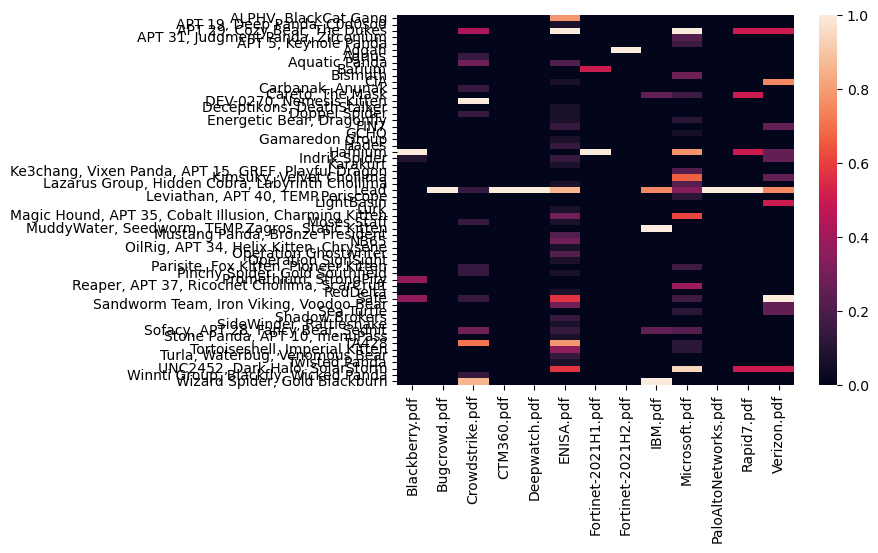

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure()
sns.heatmap(normalized_actors.loc[~(normalized_actors==0).all(axis=1)], yticklabels=True)

#### 1.2.5. Sum counts
The normalized counts per report are summed for the threats and actors, as well as the number of reports the term occurs in. 

In [166]:
total_count = normalized_actors.sum(axis=1)
reports_mentioned = normalized_actors.gt(0).sum(axis=1)

actors_results = pd.concat([total_count,reports_mentioned],axis=1)
actors_results.columns = ['total_count','reports_mentioned']

print(actors_results.shape)
actors_results.sort_values(by='total_count',ascending=False)

(58, 2)


,total_count,reports_mentioned
Lead,7.833333,10
Hafnium,3.527778,5
"APT 29, Cozy Bear, The Dukes",3.428571,5
"UNC2452, Dark Halo, SolarStorm",2.515873,4
Safe,2.244589,5
"Wizard Spider, Gold Blackburn",1.857143,2
TA428,1.611111,3
Aggah,1.000000,1
"MuddyWater, Seedworm, TEMP.Zagros, Static Kitten",1.000000,1
"DEV-0270, Nemesis Kitten",1.000000,1


In [167]:
actors_results = actors_results.merge(merge_df,left_index=True,right_index=True,how="left")

#### Observations
Groups with names that are general words end up on top, like Safe and Lead. The CIA is also mentioned in every report, probably since the CIA is reporting on attacks as well. Tropic Trooper is listed high, one of its aliases is 'Iron'. To prevent this, actor names are padded with whitespaces to make sure they are separate words. 

#### 1.2.6. Filter on sector

In [168]:
def filter_by_sector(df, sector):
    actors_sector_exploded = df.explode('victim_industries')
    return actors_sector_exploded.loc[actors_sector_exploded['victim_industries'] == sector]

actors_filtered = filter_by_sector(actors_results, SECTOR)
actors_filtered = actors_filtered.rename(columns={'total_count':'actor_weight'})
print("Actors targeting {}:".format(SECTOR))
print(actors_filtered[['actor_weight']].sort_values(by='actor_weight',ascending=False))

Actors targeting Government:
                                                    actor_weight
APT 29, Cozy Bear, The Dukes                            3.428571
Safe                                                    2.244589
Wizard Spider, Gold Blackburn                           1.857143
TA428                                                   1.611111
Aggah                                                   1.000000
MuddyWater, Seedworm, TEMP.Zagros, Static Kitten        1.000000
Kimsuky, Velvet Chollima                                0.916667
Careto, The Mask                                        0.916667
Sofacy, APT 28, Fancy Bear, Sednit                      0.900794
Magic Hound, APT 35, Cobalt Illusion, Charming ...      0.896825
Sandworm Team, Iron Viking, Voodoo Bear                 0.535714
Aquatic Panda                                           0.500000
Indrik Spider                                           0.483766
FIN7                                                    0.392

#### Observations
Tropic Trooper is the actor targeting Governments that is mentioned the most across these reports. 

## 2. Rank actors and TTPs
### 2.1 Rank actors
#### 2.1.1 Create weight and sort
TODO: Define weight calculation

In [169]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

actors_filtered['actor_weight'] = normalize(actors_filtered['actor_weight'])

actors_filtered = actors_filtered.sort_values(by='actor_weight',ascending=False)

actors_ranked = actors_filtered[['actor_weight','mitre_attack_ttps']]
unique_ttps = to_1D(actors_ranked['mitre_attack_ttps']).value_counts()

print('Number of actors:',actors_ranked.index.size)
print('Number of TTPs:\t', unique_ttps.index.size)

Number of actors: 35
Number of TTPs:	 308


<AxesSubplot:title={'center':'Top 5 actors targeting Government sector based on operations between 2018 and 2021 (normalized)'}, ylabel='Actor Name'>

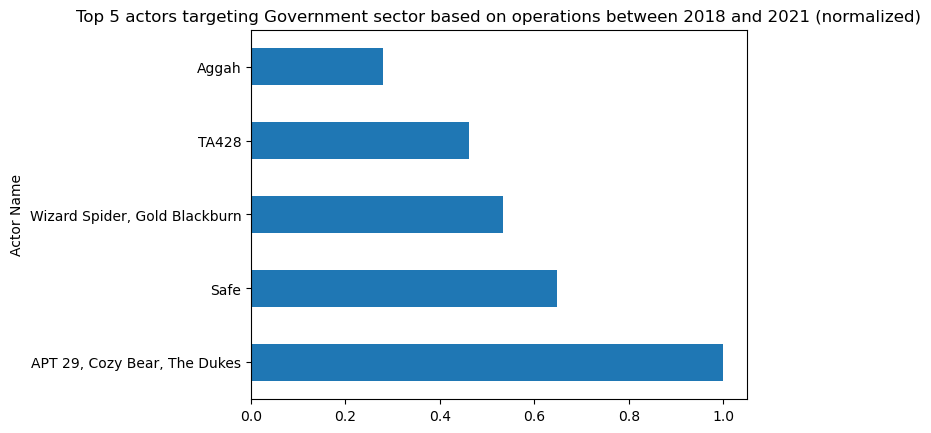

In [170]:
actor_weights = actors_ranked['actor_weight']
actor_weights.nlargest(5).plot(kind='barh',xlabel='Actor Name', title="Top 5 actors targeting {} sector based on operations between {} and {} (normalized)".format(SECTOR,YEAR-INTERVAL,YEAR))

In [171]:
actors_ranked

,actor_weight,mitre_attack_ttps
"APT 29, Cozy Bear, The Dukes",1.000000,"[T1078.004, T1001.002, T1087, T1562.004, T1560..."
Safe,0.648984,[Not Available]
"Wizard Spider, Gold Blackburn",0.534118,"[T1070.004, T1557.001, T1543.003, T1003.002, T..."
TA428,0.461176,[Not Available]
Aggah,0.280000,[Not Available]
"MuddyWater, Seedworm, TEMP.Zagros, Static Kitten",0.280000,"[T1059.007, T1057, T1087.002, T1555, T1105, T1..."
"Kimsuky, Velvet Chollima",0.255294,"[T1059.001, T1594, T1136.001, T1560.001, T1562..."
"Careto, The Mask",0.255294,[Not Available]
"Sofacy, APT 28, Fancy Bear, Sednit",0.250588,"[T1036.005, T1218.011, T1566.001, T1211, T1498..."
"Magic Hound, APT 35, Cobalt Illusion, Charming Kitten",0.249412,"[T1105, T1053.005, T1059.001, T1586.002, T1564..."


#### Observations
Since the Government sector is the most represented in the ETDA dataset, this one is chosen for the tests. 13 of the actors from the reports target this sector. APT 29 is mentioned the most across reports. This is due to their notorious SolarWinds attack in 2020, which is mentioned often. In 2021 they also launched a big spear-phishing campaign. This actor is followed by Wizard Spider, a ransomware actor that is very active.

It is mainly these two actors that exceed the others in terms of how often they are mentioned. The other mentioned actors have a weigth just below 1.0.

### 2.2. Rank TTPs
#### 2.3.1 Explode dataframe per TTP
Explode the dataframe per TTP. Now a weighting calculation can be done per TTP, based on the information provided. Information includes the actor results (and kill chain phase).

For now: the actor weights are summed per TTP to obtain a ranking per TTP. 

In [172]:
actors_ranked['number_of_actors'] = 1
actors_ttp_exploded = actors_ranked.explode('mitre_attack_ttps')

C:\Users\a.winters\AppData\Local\Temp\ipykernel_9584\823944124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_ranked['number_of_actors'] = 1


#### 2.3.2. Group by TTP and sum actor weights
Sum the actor weights.

In [173]:
actors_ttp_summed = actors_ttp_exploded.reset_index(drop=True)
ttps_ranked = actors_ttp_summed.groupby('mitre_attack_ttps').sum()
print(ttps_ranked.sort_values(by='actor_weight',ascending=False))

                   actor_weight  number_of_actors
mitre_attack_ttps                                
T1059.003              3.451658                19
T1027                  3.397647                22
T1059.001              3.329305                20
T1204.002              3.195187                18
T1588.002              3.045882                14
...                         ...               ...
T1568.001              0.004706                 1
T1218.001              0.004706                 1
T1573.002              0.004706                 1
T1137.004              0.004706                 1
T1137                  0.004706                 1

[308 rows x 2 columns]


#### 2.3.3 Enrich TTP information
Information from the ATT&CK data is used via the attackcti package.

In [174]:
from attackcti import attack_client
from pandas import json_normalize
import sys

mitre_columns = ['technique_id','technique','kill_chain_phases','id','tactic','technique_detection','impact_type']

def get_attck_dataframe(matrix = 'enterprise'):
    if  (matrix.lower() == 'enterprise'):
        # Instantiating attack_client class
        lift = attack_client()
        # Getting techniques for windows platform - enterprise matrix
        attck = lift.get_enterprise_techniques(stix_format = False)
        # Generating a dataframe with information collected
        attck = json_normalize(attck)
        return attck
    else:
        sys.exit('ERROR: Only Enterprise available!!')

attck = get_attck_dataframe()
attck = attck[mitre_columns]

ttps_enriched = pd.merge(ttps_ranked,attck,how='left',left_index=True,right_on='technique_id')
ttps_enriched.index = ttps_ranked.index
ttps_enriched['technique_name_id'] = ttps_enriched['technique'] + " (" + ttps_enriched['technique_id'] + ")"

[taxii2client.v20] [WARNING ] [2023-05-23 13:00:25,436] TAXII Server Response did not include 'Content-Range' header - results could be incomplete.
[taxii2client.v20] [WARNING ] [2023-05-23 13:00:25,473] TAXII Server Response with different amount of objects! Setting per_request=750


#### 2.3.4. Calculate weights

In [175]:
ttps_enriched['ttp_weight'] = normalize(ttps_enriched['actor_weight'])
ttps_enriched = ttps_enriched.drop(['actor_weight'],axis=1)

#### Statistics

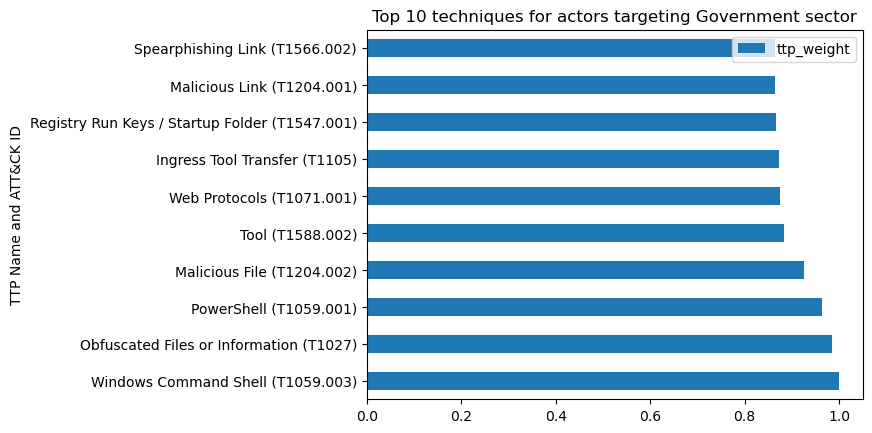

In [176]:
ttps_enriched.nlargest(10,columns='ttp_weight').plot.barh(y='ttp_weight',x='technique_name_id',xlabel="TTP Name and ATT&CK ID" ,title="Top 10 techniques for actors targeting {} sector".format(SECTOR))

# ttps_enriched.plot.hist(column="number_of_actors",bins=10, title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR))
ttps_enriched = ttps_enriched.drop(['number_of_actors'],axis=1)

Only take the top percentage of the TTPs

In [177]:
PERCENTAGE = 1

def take_percentage(percentage,df):
    top_percent = int(len(df) * PERCENTAGE)
    print("Taking {}%; {} entries".format(percentage*100,top_percent))
    return df.nlargest(top_percent,columns="ttp_weight")

def take_threshold(threshold, df):
    return df.loc[df['ttp_weight']>threshold]


ttps_enriched = take_percentage(PERCENTAGE,ttps_enriched)
# ttps_enriched = take_threshold(TTP_THRESHOLD,ttps_enriched)

Taking 100%; 308 entries


#### Observations
Within the tested Government sector, the top 10 techniques used are shown above. 
The top technique is '[Obfuscated Files or Information](https://attack.mitre.org/techniques/T1027/)', where adversaries obfuscate the contents of an executable or file by encrypting, encoding, compressing or otherwise obscuring them on the system or in transit. This is common behavior to evade defenses. 

The second technique is '[Tool]'(https://attack.mitre.org/techniques/T1588/002/), is described as "Adversaries may buy, steal or download software tools that can be used during targeting." This is a very generic technique, since the use of the use of tools is common among hackers and there exists a wide variety of tools, hence why it is listed in such a high position.

## 3. Control prioritization

### 3.1 Control Mapping
Source of the mapping: [Security Control Framework Mappings to ATT&CK](https://github.com/center-for-threat-informed-defense/attack-control-framework-mappings).

This maps controls from NIST 800-53 to MITRE ATT&CK. The following versions are considered:
- MITRE ATT&CK v10.1
- NIST 800-53 Revision 5

In [178]:
# Load ATT&CK to NIST 800-53 mapping
def get_nist_attck_mapping():
    nist_attck_mapping = pd.read_excel("data/mappings/nist800-53-r5-mappings.xlsx")
    nist_attck_mapping = nist_attck_mapping.drop(["Mapping Type","Technique Name"],axis=1)
    return nist_attck_mapping

def get_cis_attck_mapping():
    return None

def get_iso_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2022_ATTCKv82.xlsx")
    return iso_attck_mapping

Merge the TTPs with the controls. Only keep the TTPs that have a weight above a certain threshold. This threshold will be experimented with. The following values are considered:
- All TTPs
- threshold > 0.25
- threshold > 0.5
- threshold > 0.7
- threshold > 0.9

In [179]:
ttp_control_map = get_iso_attck_mapping()

ttp_control_merge = ttp_control_map.merge(ttps_enriched, left_on="Technique ID", right_on="technique_id",how="inner")
ttp_control_merge.sort_values(by='ttp_weight',inplace=True,ascending=False)
print("Number of TTPS:",ttp_control_merge['Technique ID'].value_counts().index.size)
print("Number of controls:",ttp_control_merge['Control ID'].value_counts().index.size)
ttp_control_merge

Number of TTPS: 194
Number of controls: 42


,Control ID,Technique ID,Control Name,technique_id,technique,kill_chain_phases,id,tactic,technique_detection,impact_type,technique_name_id,ttp_weight
1161,8.70,T1059.003,Protection against malware,T1059.003,Windows Command Shell,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--d1fcf083-a721-4223-aedf-bf8960...,[execution],Usage of the Windows command shell may be comm...,NaN,Windows Command Shell (T1059.003),1.000000
1162,8.19,T1059.003,Installation of software on operational systems,T1059.003,Windows Command Shell,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--d1fcf083-a721-4223-aedf-bf8960...,[execution],Usage of the Windows command shell may be comm...,NaN,Windows Command Shell (T1059.003),1.000000
537,8.16,T1027,Monitoring activities,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),0.984331
536,8.10,T1027,User endpoint devices,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),0.984331
535,8.70,T1027,Protection against malware,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),0.984331
...,...,...,...,...,...,...,...,...,...,...,...,...
1207,6.50,T1080,Responsibilities after termination or change o...,T1080,Taint Shared Content,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--246fd3c7-f5e3-466d-8787-4c13d9...,[lateral-movement],Processes that write or overwrite many files t...,NaN,Taint Shared Content (T1080),0.000000
1208,5.30,T1080,Segregation of duties,T1080,Taint Shared Content,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--246fd3c7-f5e3-466d-8787-4c13d9...,[lateral-movement],Processes that write or overwrite many files t...,NaN,Taint Shared Content (T1080),0.000000
1226,8.70,T1598.002,Protection against malware,T1598.002,Spearphishing Attachment,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--8982a661-d84c-48c0-b4ec-1db29c...,[reconnaissance],"Monitor for suspicious email activity, such as...",NaN,Spearphishing Attachment (T1598.002),0.000000
1227,6.30,T1598.002,"Information security awareness, education and ...",T1598.002,Spearphishing Attachment,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--8982a661-d84c-48c0-b4ec-1db29c...,[reconnaissance],"Monitor for suspicious email activity, such as...",NaN,Spearphishing Attachment (T1598.002),0.000000


Get TTPs incl number of controls that mitigate them

<AxesSubplot:title={'center':'Distribution of TTP weights for actors targeting Government sector'}, ylabel='Frequency'>

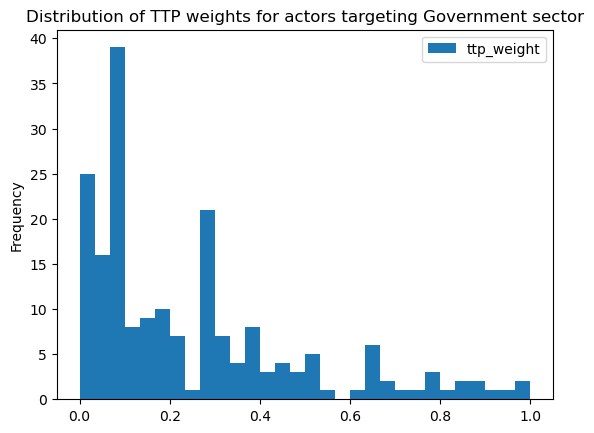

In [180]:
ttp_control_merge[['Technique ID','ttp_weight']].drop_duplicates().plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR))
# ttp_control_merge['ttp_weight'].plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR),xlabel="TTP weights")

**Observations**

The TTP weights are a normalised summation of the actor weights. This means, the higher the TTP weight, the more (high weighted) actors share this TTP.
We can see that the distribution of TTP weights is a right-skewed distribution. This is expected, since this means that the number of TTPs that are shared by these actors is 

<AxesSubplot:title={'center':'Top controls by number of mitigated TTPs. Top 100% of TTPS'}, ylabel='Control ID,Control Name'>

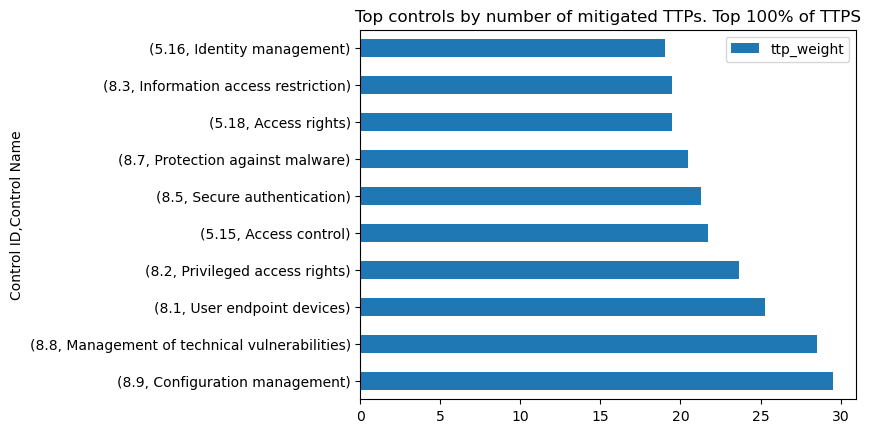

In [181]:
# ttp_control_merge[['Control ID','Control Name']].value_counts().nlargest(10).plot(kind='barh',title="Number of selected TTPs mitigated per control")

ttp_control_ranked = ttp_control_merge.groupby(['Control ID','Control Name']).sum()
ttp_control_ranked.sort_values(by='ttp_weight',ascending=False)

# ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. No TTP threshold")
ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. Top {}% of TTPS".format(PERCENTAGE*100))

#### Observations
There are some controls that map to a lot of TTPs. For the complete results for the ‘Government’ sector, there are 215 TTPs and 106 controls. Merging the two gives a resulting set of 2545 mappings. Since there is no measure of control effectiveness to a TTP in this data, they are sorted based on the TTPs they control and their respective weights.

There are two ways to approach the control mapping, either a generic approach or a targeted approach.
- Targeted: Take the most prominent TTPs, those with the highest weights, and display the controls for this. 
- Generic: Take the complete, or near-complete, set of TTPs used by the actors. Rank the controls based on the number of TTPs they control and their respective weights. The downside of this is that controls that map to a large number of TTPs will probably always end up on top. This means that the initial TTP ranking matters less.

When simply counting the number of TTPs that a control covers, only the general ones come to the top. Even if the TTP weights are considered. One possibility to solve this, is to only take the top x% of TTPs into consideration.